#Library

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np

import nltk
nltk.download("popular")
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [109]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.shape, df_test.shape

((1500, 2), (500, 1))

In [110]:
df_train.head()

,reviews_content,category
0,airplane ! is considered among many to be the ...,positive
1,you've got to love disney . \nno matter what t...,positive
2,""" the tailor of panama "" is a different kind ...",positive
3,"the characters in jonathan lynn's "" the whole ...",negative
4,"vikings v . bears ? \nno , this isn't the line...",negative


In [111]:
df_test.head()

,reviews_content
0,"towards the middle of "" the sweet hereafter , ..."
1,wild things is a suspenseful thriller starring...
2,hong kong cinema has been going through a bad ...
3,while alex browning ( devon sawa ) waits at jf...
4,sometimes i find 19th century british costume ...


#Preprocessing

## Missing Value

In [112]:
#Missing Value
df_test.isna().sum()

reviews_content    0
dtype: int64

In [113]:
#Missing Value
df_train.isna().sum()

reviews_content    0
category           0
dtype: int64

## Duplicate Value

In [114]:
#Duplicate
duplicate_rows = df_train[df_train.duplicated()]
duplicate_rows

,reviews_content,category


In [115]:
#Duplicate
duplicate_rows = df_test[df_test.duplicated()]
duplicate_rows

,reviews_content


#Stopwords

In [116]:
# stopwords
from nltk.corpus import stopwords
total_stopwords = set(stopwords.words('english'))

# subtract negative stop words like no, not, don't etc.. from total_stopwords
negative_stop_words = set(word for word in total_stopwords
                          if "n't" in word or 'no' in word)

final_stopwords = total_stopwords - negative_stop_words

#
final_stopwords.add("one")
print(final_stopwords)

{'or', 'to', 'was', 'who', 'y', 'some', 'doing', 's', 'having', 'it', 'theirs', 'yours', 'wasn', 'after', 'its', 't', 'between', 'be', "should've", 'them', 'on', 'our', 'one', 'through', 'very', 'your', 'aren', 'myself', 'can', 'won', 'as', 'these', 'll', 'needn', 'yourselves', 'once', 'while', 'had', 'at', 'below', 'own', 'of', 'hers', 'mustn', 'over', 'the', "you'd", 'were', 'if', 'up', 'when', 'didn', 'than', 'further', 'here', 'you', 'mightn', 'themselves', 'am', 'until', 'where', 'any', 'are', 'under', 'ma', 'for', 'same', 'a', 'will', 'above', 'so', 'my', 'wouldn', 'all', 'because', 'his', 'those', 'with', "you're", 'in', 'shan', 'by', 'against', 'few', "she's", 'there', 'ours', 'into', 'haven', 've', 'him', 'her', 'again', 'has', 'most', 're', 'about', 'being', 'both', 'they', 'itself', "it's", 'herself', 'from', 'hadn', "that'll", 'ain', 'which', 'that', 'what', 'how', 'more', 'then', 'himself', 'down', "you've", 'why', 'don', 'before', 'each', 'whom', 'and', 'do', 'we', 'o', '

#Remove unwanted words

In [117]:
from nltk.stem import PorterStemmer
import re
import string

#stemming object
stemmer = PorterStemmer()

# ---------------------------------------------
HTMLTAGS = re.compile('<.*?>')
table = str.maketrans(dict.fromkeys(string.punctuation))
remove_digits = str.maketrans('', '', string.digits)
MULTIPLE_WHITESPACE = re.compile(r"\s+")
# ---------------------------------------------

# Data Preprocessing

In [118]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [119]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

## Preprocessing Data Train

In [120]:
# Before Preprocessing
print("Before preprocessing : ")
df_train.reviews_content.iloc[6]

Before preprocessing : 


'plot : a rich psychiatrist with a great home life gets his cute daughter kidnapped by some bad guys who want him to extract some information from the mind of one of his nutty patients . \nof course , the patient is not cooperative and the doctor only has a few hours to comply with their demands , before they kill his daughter . \npretty good premise , no ? \ncritique : if you\'re not a fan of movies packed with plot holes , inconsistencies and yes , even more plot holes , heed my words and skip this hollow thriller . \nand i don\'t like saying that either , since this film actually had some potential and started off pretty well . \nsure , the story is basically just an amalgamation of ransom , primal fear and nick of time pureed into one , but the whole " psychiatrist working against the clock " thing , actually had me engaged at first . \nbut it\'s at about the halfway mark of this movie , that the bottom drops out and all that we\'re left with are a lot of questions and very few pla

In [121]:
#After Preprocessing
df_trainclean = df_train.copy()
df_trainclean['reviews_content'] = df_train['reviews_content'].apply(preprocess_text)
print("After preprocessing : ")
df_trainclean.reviews_content.iloc[6]

After preprocessing 2 : 


'plot rich psychiatrist great home life gets cute daughter kidnapped bad guys want extract information mind one nutty patients course patient cooperative doctor hours comply demands kill daughter pretty good premise critique fan movies packed plot holes inconsistencies yes even plot holes heed words skip hollow thriller like saying either since film actually potential started pretty well sure story basically amalgamation ransom primal fear nick time pureed one whole psychiatrist working clock thing actually engaged first halfway mark movie bottom drops left lot questions plausible answers get overly smart kid manages pull one bad guys get weak woman leg cast beating crap tough bad guy get douglas character new york uppedity psychiatrist suddenly turning action hero moves attitude boot film main plot point would bad guys still give crap thing years even would give shrink day end part waited years another days set another heist instead tell bad movie otherwise many many ugh whatever case

## Preprocessing Data Test

In [122]:
#Before Preprocessing
print("Before preprocessing : ")
df_test.reviews_content.iloc[6]

Before preprocessing df_test : 


'after a marketing windup of striking visuals and the promise of star caliber actors , mission to mars ends up throwing a whiffleball . \nfiercely unoriginal , director depalma cobbles together a film by borrowing heavily from what has gone before him . \nthere are aliens similar to those in close encounters of the third kind . \nthe stranded astronaut theme is reminiscent of robinson crusoe on mars . \nthe astronauts encounter space flight difficulties that smack of apollo 13 . \ninterior spacecraft visuals are redolent of 2001 : a space odyssey . \ninstead of using these components as a launching pad to create his own movie , de palma stops right there , refusing to infuse the film with anything even remotely resembling cleverness or heart . \nmission to mars takes it\'s first wobbly steps at a pre-launch barbeque in which the perfunctory character introductions are done . \nduring these surface scans of the characters , we learn that jim mcconnell ( sinise ) has lost his wife . \nit

In [123]:
# After Preprocessing
df_testclean = df_test.copy()
df_testclean['reviews_content'] = df_test['reviews_content'].apply(preprocess_text)
print("After preprocessing : ")
df_testclean.reviews_content.iloc[6]

After preprocessing : 


'marketing windup striking visuals promise star caliber actors mission mars ends throwing whiffleball fiercely unoriginal director depalma cobbles together film borrowing heavily gone aliens similar close encounters third kind stranded astronaut theme reminiscent robinson crusoe mars astronauts encounter space flight difficulties smack apollo interior spacecraft visuals redolent space odyssey instead using components launching pad create movie de palma stops right refusing infuse film anything even remotely resembling cleverness heart mission mars takes first wobbly steps pre launch barbeque perfunctory character introductions done surface scans characters learn jim mcconnell sinise lost wife plot point revisted throughout film jackhammer subtlety rest crew exhibit bland affability contentiousness friction add dramatic tension men women confined close quarters extended length time maybe depalma going comraderie right stuff movie astronauts embers personality warm us technical aspects y

In [124]:
df_trainclean.shape , df_testclean.shape

((1500, 2), (500, 1))

#Split

In [125]:
X = df_trainclean['reviews_content'].values
y = df_trainclean['category'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=40)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1200,), (300,), (1200,), (300,))

# Feature Extraction

In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
df_test_tfidf = tfidf_vectorizer.transform(df_testclean['reviews_content'])


X_train_tfidf.shape , X_test_tfidf.shape, df_test_tfidf.shape

((1200, 5000), (300, 5000), (500, 5000))

# Model Development

## Support Vector Machine

In [127]:
model_svm = SVC(kernel='linear')
model_svm.fit(X_train_tfidf, y_train)
y_pred_svc = model_svm.predict(X_test_tfidf)

In [128]:
print("Hasil prediksi:")
for i, pred in enumerate(y_pred_svc):
    print(f"Data ke-{i+1}: {pred}")

Hasil prediksi:
Data ke-1: positive
Data ke-2: negative
Data ke-3: negative
Data ke-4: positive
Data ke-5: negative
Data ke-6: negative
Data ke-7: negative
Data ke-8: negative
Data ke-9: positive
Data ke-10: positive
Data ke-11: positive
Data ke-12: negative
Data ke-13: positive
Data ke-14: negative
Data ke-15: positive
Data ke-16: positive
Data ke-17: positive
Data ke-18: negative
Data ke-19: positive
Data ke-20: negative
Data ke-21: negative
Data ke-22: positive
Data ke-23: negative
Data ke-24: positive
Data ke-25: negative
Data ke-26: positive
Data ke-27: positive
Data ke-28: positive
Data ke-29: negative
Data ke-30: negative
Data ke-31: positive
Data ke-32: negative
Data ke-33: positive
Data ke-34: positive
Data ke-35: negative
Data ke-36: positive
Data ke-37: positive
Data ke-38: positive
Data ke-39: positive
Data ke-40: positive
Data ke-41: negative
Data ke-42: negative
Data ke-43: negative
Data ke-44: positive
Data ke-45: positive
Data ke-46: negative
Data ke-47: positive
Data k

### Predict Model

In [129]:
label_svm = model_svm.predict(df_test_tfidf)

In [130]:
print("Hasil prediksi:")
for i, pred in enumerate(label_svm):
    print(f"Data ke-{i+1}: {pred}")

Hasil prediksi:
Data ke-1: positive
Data ke-2: positive
Data ke-3: positive
Data ke-4: positive
Data ke-5: positive
Data ke-6: positive
Data ke-7: negative
Data ke-8: positive
Data ke-9: positive
Data ke-10: negative
Data ke-11: positive
Data ke-12: positive
Data ke-13: positive
Data ke-14: negative
Data ke-15: negative
Data ke-16: negative
Data ke-17: positive
Data ke-18: negative
Data ke-19: positive
Data ke-20: positive
Data ke-21: positive
Data ke-22: negative
Data ke-23: negative
Data ke-24: negative
Data ke-25: positive
Data ke-26: positive
Data ke-27: negative
Data ke-28: positive
Data ke-29: positive
Data ke-30: positive
Data ke-31: positive
Data ke-32: negative
Data ke-33: negative
Data ke-34: positive
Data ke-35: negative
Data ke-36: positive
Data ke-37: positive
Data ke-38: negative
Data ke-39: positive
Data ke-40: negative
Data ke-41: positive
Data ke-42: positive
Data ke-43: positive
Data ke-44: negative
Data ke-45: negative
Data ke-46: positive
Data ke-47: negative
Data k

### Accuracy

In [131]:
accuracysvm = accuracy_score(y_test, y_pred_svc)
print("Akurasi:", accuracysvm)


Akurasi: 0.8433333333333334


### Classification Report

In [132]:
#Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_svc))

Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.82      0.83       143
    positive       0.84      0.87      0.85       157

    accuracy                           0.84       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.84      0.84      0.84       300



### Confussion Matrix

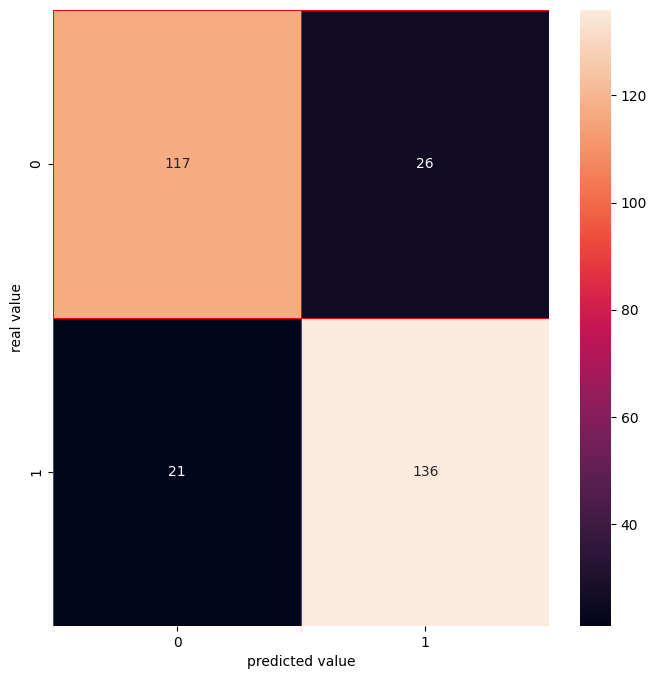

In [133]:
#Confussion Matrix
cm_svc=confusion_matrix(y_test,y_pred_svc)

#cm visualization
f,ax=plt.subplots(figsize=(8,8))
sns.heatmap(cm_svc,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("predicted value")
plt.ylabel("real value")
plt.show()


##Naive Bayes

In [134]:
model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, y_train)
y_pred_nb = model_nb.predict(X_test_tfidf)

In [135]:
print("Hasil prediksi:")
for i, pred in enumerate(y_pred_nb):
    print(f"Data ke-{i+1}: {pred}")

Hasil prediksi:
Data ke-1: positive
Data ke-2: negative
Data ke-3: negative
Data ke-4: negative
Data ke-5: negative
Data ke-6: negative
Data ke-7: negative
Data ke-8: negative
Data ke-9: positive
Data ke-10: positive
Data ke-11: positive
Data ke-12: negative
Data ke-13: positive
Data ke-14: negative
Data ke-15: positive
Data ke-16: positive
Data ke-17: positive
Data ke-18: negative
Data ke-19: positive
Data ke-20: negative
Data ke-21: negative
Data ke-22: positive
Data ke-23: negative
Data ke-24: positive
Data ke-25: negative
Data ke-26: negative
Data ke-27: positive
Data ke-28: positive
Data ke-29: negative
Data ke-30: negative
Data ke-31: negative
Data ke-32: negative
Data ke-33: positive
Data ke-34: negative
Data ke-35: negative
Data ke-36: positive
Data ke-37: negative
Data ke-38: positive
Data ke-39: positive
Data ke-40: negative
Data ke-41: negative
Data ke-42: positive
Data ke-43: negative
Data ke-44: positive
Data ke-45: negative
Data ke-46: negative
Data ke-47: negative
Data k

### Predict Model

In [136]:
label_nb = model_nb.predict(df_test_tfidf)

In [137]:
print("Hasil prediksi:")
for i, pred in enumerate(label_nb):
    print(f"Data ke-{i+1}: {pred}")

Hasil prediksi:
Data ke-1: positive
Data ke-2: negative
Data ke-3: negative
Data ke-4: positive
Data ke-5: positive
Data ke-6: positive
Data ke-7: negative
Data ke-8: positive
Data ke-9: positive
Data ke-10: negative
Data ke-11: negative
Data ke-12: positive
Data ke-13: negative
Data ke-14: negative
Data ke-15: negative
Data ke-16: negative
Data ke-17: positive
Data ke-18: negative
Data ke-19: negative
Data ke-20: positive
Data ke-21: positive
Data ke-22: negative
Data ke-23: negative
Data ke-24: negative
Data ke-25: negative
Data ke-26: positive
Data ke-27: positive
Data ke-28: positive
Data ke-29: positive
Data ke-30: positive
Data ke-31: positive
Data ke-32: negative
Data ke-33: negative
Data ke-34: positive
Data ke-35: negative
Data ke-36: positive
Data ke-37: positive
Data ke-38: negative
Data ke-39: positive
Data ke-40: negative
Data ke-41: negative
Data ke-42: positive
Data ke-43: positive
Data ke-44: negative
Data ke-45: negative
Data ke-46: positive
Data ke-47: negative
Data k

### Accuracy

In [138]:
accuracynb = accuracy_score(y_test, y_pred_nb)
print("Akurasi:", accuracynb)

Akurasi: 0.82


### Classification Report

In [139]:
#Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))

Classification Report:
              precision    recall  f1-score   support

    negative       0.77      0.88      0.82       143
    positive       0.88      0.76      0.82       157

    accuracy                           0.82       300
   macro avg       0.82      0.82      0.82       300
weighted avg       0.83      0.82      0.82       300



### Confussion Matrix

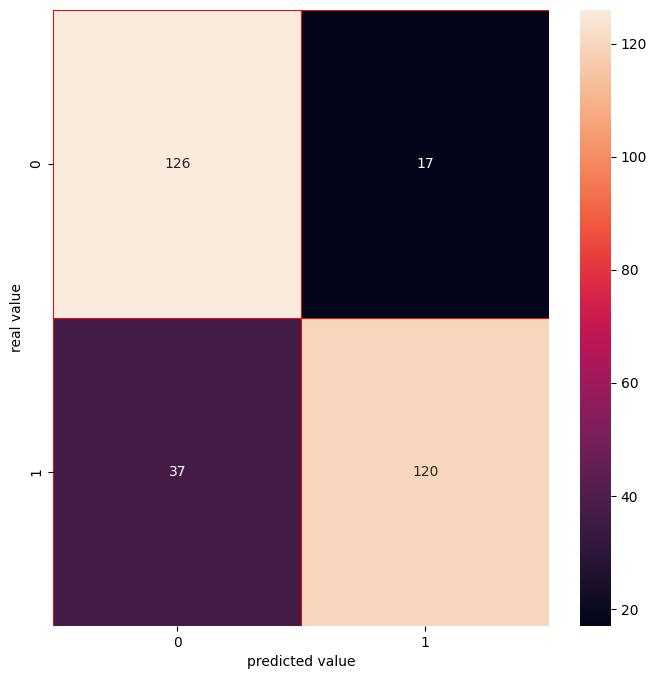

In [140]:
#Confussion Matrix
cm_nb=confusion_matrix(y_test,y_pred_nb)

#cm visualization
f,ax=plt.subplots(figsize=(8,8))
sns.heatmap(cm_nb,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("predicted value")
plt.ylabel("real value")
plt.show()


## Random Forest

In [141]:
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)

In [142]:
print("Hasil prediksi:")
for i, pred in enumerate(y_pred_rf):
    print(f"Data ke-{i+1}: {pred}")

Hasil prediksi:
Data ke-1: negative
Data ke-2: negative
Data ke-3: negative
Data ke-4: positive
Data ke-5: negative
Data ke-6: negative
Data ke-7: negative
Data ke-8: negative
Data ke-9: positive
Data ke-10: positive
Data ke-11: positive
Data ke-12: negative
Data ke-13: negative
Data ke-14: positive
Data ke-15: positive
Data ke-16: positive
Data ke-17: positive
Data ke-18: negative
Data ke-19: negative
Data ke-20: negative
Data ke-21: negative
Data ke-22: positive
Data ke-23: positive
Data ke-24: negative
Data ke-25: negative
Data ke-26: negative
Data ke-27: positive
Data ke-28: positive
Data ke-29: negative
Data ke-30: negative
Data ke-31: positive
Data ke-32: positive
Data ke-33: negative
Data ke-34: positive
Data ke-35: negative
Data ke-36: positive
Data ke-37: negative
Data ke-38: negative
Data ke-39: positive
Data ke-40: negative
Data ke-41: negative
Data ke-42: negative
Data ke-43: negative
Data ke-44: positive
Data ke-45: negative
Data ke-46: negative
Data ke-47: positive
Data k

### Predict Model

In [143]:
label_rf = rf.predict(df_test_tfidf)

In [144]:
print("Hasil prediksi:")
for i, pred in enumerate(label_rf):
    print(f"Data ke-{i+1}: {pred}")

Hasil prediksi:
Data ke-1: positive
Data ke-2: positive
Data ke-3: positive
Data ke-4: positive
Data ke-5: positive
Data ke-6: positive
Data ke-7: negative
Data ke-8: positive
Data ke-9: negative
Data ke-10: negative
Data ke-11: negative
Data ke-12: positive
Data ke-13: negative
Data ke-14: negative
Data ke-15: negative
Data ke-16: negative
Data ke-17: positive
Data ke-18: negative
Data ke-19: positive
Data ke-20: negative
Data ke-21: positive
Data ke-22: negative
Data ke-23: negative
Data ke-24: negative
Data ke-25: positive
Data ke-26: positive
Data ke-27: negative
Data ke-28: positive
Data ke-29: negative
Data ke-30: positive
Data ke-31: negative
Data ke-32: negative
Data ke-33: negative
Data ke-34: positive
Data ke-35: negative
Data ke-36: positive
Data ke-37: positive
Data ke-38: negative
Data ke-39: positive
Data ke-40: negative
Data ke-41: negative
Data ke-42: positive
Data ke-43: positive
Data ke-44: negative
Data ke-45: negative
Data ke-46: positive
Data ke-47: negative
Data k

### Accuracy

In [145]:
accuracyrf = accuracy_score(y_test, y_pred_rf)
print("Akurasi:", accuracyrf)


Akurasi: 0.7666666666666667


### Classification Report

In [146]:
#Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.88      0.78       143
    positive       0.86      0.66      0.75       157

    accuracy                           0.77       300
   macro avg       0.78      0.77      0.77       300
weighted avg       0.79      0.77      0.76       300



### Confussion Matrix

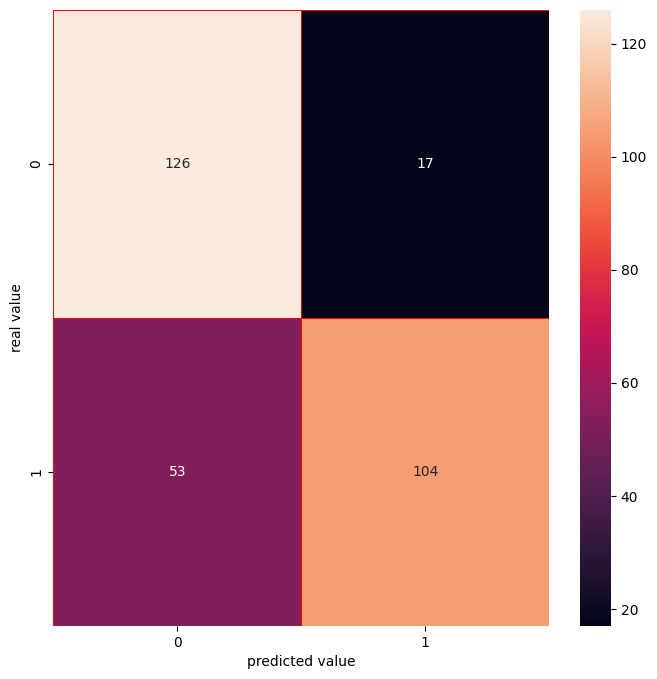

In [147]:
#Confussion Matrix
cm_rf=confusion_matrix(y_test,y_pred_rf)

#cm visualization
f,ax=plt.subplots(figsize=(8,8))
sns.heatmap(cm_rf,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("predicted value")
plt.ylabel("real value")
plt.show()


##Logistic Regression

In [148]:
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

In [149]:
print("Hasil prediksi:")
for i, pred in enumerate(y_pred_lr):
    print(f"Data ke-{i+1}: {pred}")

Hasil prediksi:
Data ke-1: positive
Data ke-2: negative
Data ke-3: negative
Data ke-4: positive
Data ke-5: negative
Data ke-6: negative
Data ke-7: negative
Data ke-8: negative
Data ke-9: positive
Data ke-10: positive
Data ke-11: positive
Data ke-12: negative
Data ke-13: positive
Data ke-14: negative
Data ke-15: positive
Data ke-16: positive
Data ke-17: positive
Data ke-18: negative
Data ke-19: positive
Data ke-20: negative
Data ke-21: negative
Data ke-22: positive
Data ke-23: negative
Data ke-24: positive
Data ke-25: negative
Data ke-26: negative
Data ke-27: positive
Data ke-28: positive
Data ke-29: negative
Data ke-30: negative
Data ke-31: negative
Data ke-32: negative
Data ke-33: positive
Data ke-34: positive
Data ke-35: negative
Data ke-36: positive
Data ke-37: positive
Data ke-38: positive
Data ke-39: positive
Data ke-40: positive
Data ke-41: negative
Data ke-42: positive
Data ke-43: negative
Data ke-44: positive
Data ke-45: positive
Data ke-46: negative
Data ke-47: positive
Data k

### Predict Model

In [150]:
label_lr = lr.predict(df_test_tfidf)

In [151]:
print("Hasil prediksi:")
for i, pred in enumerate(label_lr):
    print(f"Data ke-{i+1}: {pred}")

Hasil prediksi:
Data ke-1: positive
Data ke-2: positive
Data ke-3: positive
Data ke-4: positive
Data ke-5: positive
Data ke-6: positive
Data ke-7: negative
Data ke-8: positive
Data ke-9: positive
Data ke-10: positive
Data ke-11: positive
Data ke-12: positive
Data ke-13: negative
Data ke-14: negative
Data ke-15: negative
Data ke-16: negative
Data ke-17: positive
Data ke-18: negative
Data ke-19: positive
Data ke-20: positive
Data ke-21: positive
Data ke-22: negative
Data ke-23: negative
Data ke-24: negative
Data ke-25: negative
Data ke-26: positive
Data ke-27: positive
Data ke-28: positive
Data ke-29: positive
Data ke-30: positive
Data ke-31: positive
Data ke-32: negative
Data ke-33: negative
Data ke-34: positive
Data ke-35: negative
Data ke-36: positive
Data ke-37: positive
Data ke-38: negative
Data ke-39: positive
Data ke-40: negative
Data ke-41: negative
Data ke-42: positive
Data ke-43: positive
Data ke-44: negative
Data ke-45: negative
Data ke-46: positive
Data ke-47: negative
Data k

### Accuracy

In [152]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Akurasi:", accuracy_lr)

Akurasi: 0.8366666666666667


### Classification Report

In [153]:
#Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.84      0.83       143
    positive       0.85      0.83      0.84       157

    accuracy                           0.84       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.84      0.84      0.84       300



### Confussion Matrix

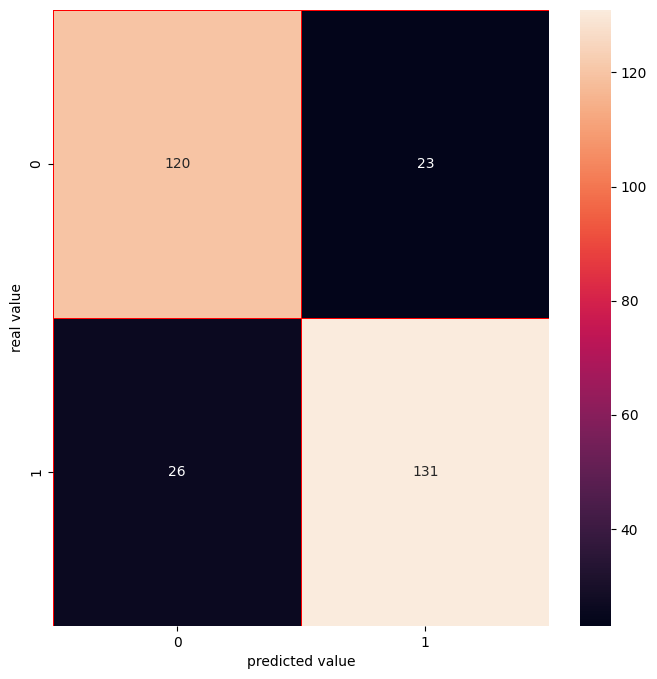

In [154]:
#Confussion Matrix
cm_lr=confusion_matrix(y_test,y_pred_lr)

#cm visualization
f,ax=plt.subplots(figsize=(8,8))
sns.heatmap(cm_lr,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("predicted value")
plt.ylabel("real value")
plt.show()


## Ensemble Models

In [155]:
# Building an ensemble with Voting techniques

model_svm = SVC(kernel='linear', probability=True, random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

ensemble_model = VotingClassifier(estimators=[('svm', model_svm), ('log_reg', lr), ('rf', rf)], voting='soft')
ensemble_model.fit(X_train_tfidf, y_train)
y_pred_ens = ensemble_model.predict(X_test_tfidf)

In [156]:
print("Hasil prediksi:")
for i, pred in enumerate(y_pred_ens):
    print(f"Data ke-{i+1}: {pred}")

Hasil prediksi:
Data ke-1: negative
Data ke-2: negative
Data ke-3: negative
Data ke-4: positive
Data ke-5: negative
Data ke-6: negative
Data ke-7: negative
Data ke-8: negative
Data ke-9: positive
Data ke-10: positive
Data ke-11: positive
Data ke-12: negative
Data ke-13: positive
Data ke-14: negative
Data ke-15: positive
Data ke-16: positive
Data ke-17: positive
Data ke-18: negative
Data ke-19: positive
Data ke-20: negative
Data ke-21: negative
Data ke-22: positive
Data ke-23: negative
Data ke-24: positive
Data ke-25: negative
Data ke-26: positive
Data ke-27: positive
Data ke-28: positive
Data ke-29: negative
Data ke-30: negative
Data ke-31: positive
Data ke-32: negative
Data ke-33: positive
Data ke-34: positive
Data ke-35: negative
Data ke-36: positive
Data ke-37: positive
Data ke-38: positive
Data ke-39: positive
Data ke-40: positive
Data ke-41: negative
Data ke-42: negative
Data ke-43: negative
Data ke-44: positive
Data ke-45: positive
Data ke-46: negative
Data ke-47: positive
Data k

### Model Predict

In [157]:
label_ens = ensemble_model.predict(df_test_tfidf)

In [158]:
print("Hasil prediksi:")
for i, predict in enumerate(label_ens):
    print(f"Data ke-{i+1}: {predict}")

Hasil prediksi:
Data ke-1: positive
Data ke-2: positive
Data ke-3: positive
Data ke-4: positive
Data ke-5: positive
Data ke-6: positive
Data ke-7: negative
Data ke-8: positive
Data ke-9: positive
Data ke-10: negative
Data ke-11: negative
Data ke-12: positive
Data ke-13: positive
Data ke-14: negative
Data ke-15: negative
Data ke-16: negative
Data ke-17: positive
Data ke-18: negative
Data ke-19: positive
Data ke-20: positive
Data ke-21: positive
Data ke-22: negative
Data ke-23: negative
Data ke-24: negative
Data ke-25: positive
Data ke-26: positive
Data ke-27: negative
Data ke-28: positive
Data ke-29: positive
Data ke-30: positive
Data ke-31: positive
Data ke-32: negative
Data ke-33: negative
Data ke-34: positive
Data ke-35: negative
Data ke-36: positive
Data ke-37: positive
Data ke-38: negative
Data ke-39: positive
Data ke-40: negative
Data ke-41: negative
Data ke-42: positive
Data ke-43: positive
Data ke-44: negative
Data ke-45: negative
Data ke-46: positive
Data ke-47: negative
Data k

### Accuracy

In [159]:
accuracy_ens = accuracy_score(y_test, y_pred_ens)
print("Accuracy:", accuracy_ens)

Accuracy: 0.8433333333333334


### Classification Report

In [160]:
#Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_ens))

Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.84      0.84       143
    positive       0.85      0.85      0.85       157

    accuracy                           0.84       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.84      0.84      0.84       300



### Confussion Matrix

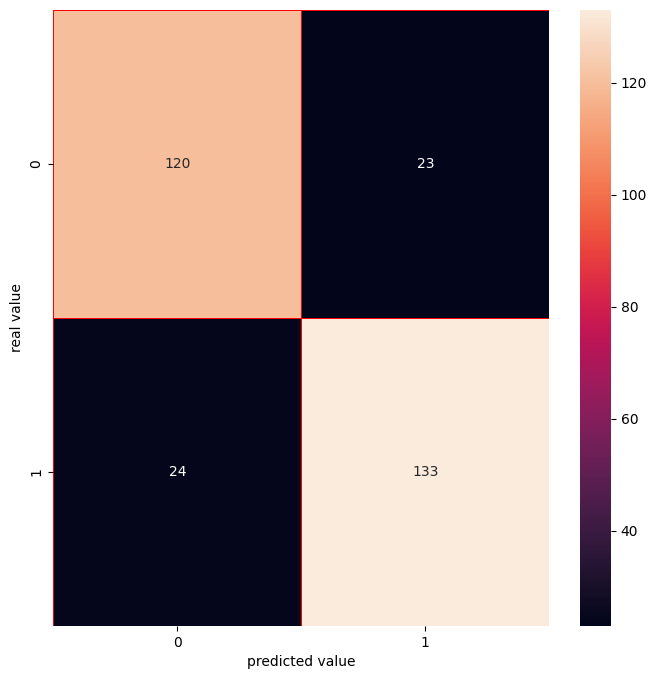

In [161]:
#Confussion Matrix
cm_ens=confusion_matrix(y_test,y_pred_ens)

#cm visualization
f,ax=plt.subplots(figsize=(8,8))
sns.heatmap(cm_ens,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("predicted value")
plt.ylabel("real value")
plt.show()


# Model Comparison & Summary

In [162]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Naive Bayes',  'Random Forest' ,'Logistic Regression', 'Ensemble' ],
    'Accuracy': [accuracysvm, accuracynb, accuracyrf, accuracy_lr, accuracy_ens]})
models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
0,Support Vector Machines,0.843333
4,Ensemble,0.843333
3,Logistic Regression,0.836667
1,Naive Bayes,0.820000
2,Random Forest,0.766667


#Conclusion & Recommendation

Considering the accuracy of the five text classification models, it is recommended to use the Support Vector Machines (SVM) model due to its highest accuracy rate of 0.843333. Additionally, the Ensemble model also demonstrates good performance with the same accuracy. Both of these models can be considered as primary choices when facing text classification tasks.